# Production statistics

In [95]:
import math

import pandas as pd
from molmass import Formula
import reframed

In [96]:
import sys
sys.path.append("../functions/")
import general_functions as general_func

import colors_MAGs
import scipy.stats as stats

In [97]:
import numpy as np

### Load universal model

In [98]:
model_uni = reframed.load_cbmodel("/Users/idunmariaburgos/universal_model_extension/output/universe_bacteria.xml")

### Load data 

In [99]:
all_mags_paper = general_func.read_allmags_data()

In [100]:
SC1_C = pd.read_csv("../output/steadiercom_sample_0.1.3/results/results_99_SC1_C.tsv",sep="\t")
SC2_C = pd.read_csv("../output/steadiercom_sample_0.1.3/results/results_99_SC2_C.tsv",sep="\t")
SC1_X = pd.read_csv("../output/steadiercom_sample_0.1.3/results/results_99_SC1_X.tsv",sep="\t")

steadier_sample = pd.concat([SC1_C,SC2_C,SC1_X])
steadier_sample = steadier_sample[(steadier_sample.frequency>0.1) & (steadier_sample.rate>1e-6)]

In [101]:
steadier_sample_prod = steadier_sample[(steadier_sample.receiver=="environment") ].copy()

### Prepare to process data

In [102]:
chebi_lut, chebi_interesting, chebi_colors_ser = colors_MAGs.chebi_rxn_color_func(rxn_based=False)

**Change names of family for readability and better grouping**

In [103]:
all_mags_paper_reduced = all_mags_paper.copy()

all_mags_paper_reduced[all_mags_paper_reduced["new_coverage"]>10][["Source","Substrate","Family","new_coverage"]].sort_values(["Source","Substrate"])

all_mags_paper_reduced["Family"] = all_mags_paper.apply(lambda row: "f_"+row.Family,axis=1)

total_members_family = all_mags_paper_reduced.groupby("Family").count()["Source"].to_dict()
all_mags_paper_reduced["Family"] = all_mags_paper_reduced.apply(lambda row: row.Family if total_members_family[row.Family]>1 else "Other",axis=1)


In [104]:
def mag2family(all_mags_paper):  
    
    family_groups = all_mags_paper.groupby("Family").groups
    mag2family_dict = {mag:family for family,mags in family_groups.items() for mag in mags}
    
    return family_groups,mag2family_dict

**Create dictionaries to translate components into larger groups - MAG-> family, compound-> super_class**

In [105]:
MAGs_steady_com = list(set(steadier_sample_prod.donor.values))

MAG2sour_sub_id = pd.read_csv("../output/MAG2community_id.tsv",sep="\t",header=None)
MAG2sour_sub_id.columns=["MAG","community_id"]

met2superclass_dict = pd.read_csv("../output/met_chebi_class.tsv",sep="\t",index_col=0)["self defined super class"].to_dict()

family_groups,mag2family_dict = mag2family(all_mags_paper_reduced)

In [106]:
def family_donor(row):
    if row.donor=="environment":
        return "environment"
    else:
        return mag2family_dict[row.donor]


def family_receiver(row):
    if row.receiver=="environment":
        return "environment"
    else:
        return mag2family_dict[row.receiver]


In [107]:
def met2metname(met):
    met_name = model_uni.metabolites[met].name
    return met_name

### Process data

**All compounds**

In [108]:
steadier_sample.loc[:,"family_donor"] = steadier_sample.apply(family_donor,axis=1).copy()
steadier_sample.loc[:,"family_receiver"] = steadier_sample.apply(family_receiver,axis=1).copy()
steadier_sample = steadier_sample[steadier_sample.compound.isin(met2superclass_dict.keys())].copy()
steadier_sample.loc[:,"super_class"] = steadier_sample.apply(lambda x: met2superclass_dict[x.compound],axis=1)

compounds = steadier_sample["compound"].map(met2metname)
steadier_sample.drop("compound",axis=1,inplace=True)
steadier_sample.loc[:,"compound"] = compounds


**Compounds produced**

In [109]:
steadier_sample_prod.loc[:,"family_donor"] = steadier_sample_prod.apply(family_donor,axis=1).copy()
#steadier_sample_prod.loc[:,"family_receiver"] = steadier_sample_prod.apply(family_receiver,axis=1).copy()
steadier_sample_prod = steadier_sample_prod[steadier_sample_prod.compound.isin(met2superclass_dict.keys())].copy()
steadier_sample_prod.loc[:,"super_class"] = steadier_sample_prod.apply(lambda x: met2superclass_dict[x.compound],axis=1)

compounds = steadier_sample_prod["compound"].map(met2metname)
steadier_sample_prod.drop("compound",axis=1,inplace=True)
steadier_sample_prod.loc[:,"compound"] = compounds

# FILTERS OUT UNINTERESTING COMPOUNDS
steadier_sample_prod = steadier_sample_prod[steadier_sample_prod.super_class.isin(chebi_lut.keys())].copy()

steadier_sample_prod["mass_rate*frequency"]=steadier_sample_prod["mass_rate"]*steadier_sample_prod["frequency"]

In [110]:
steadier_sample_prod

,donor,receiver,mass_rate,rate,frequency,community,medium,family_donor,super_class,compound,mass_rate*frequency
4,CH13-bin.12,environment,0.014176,0.240099,1.00,CD_A,SC1_C,f_Fibrobacteraceae,carboxylic acids and anions,Acetate,1.417635e-02
6,CH15-bin.0,environment,0.012775,0.216366,0.99,CD_P,SC1_C,f_Treponemataceae,carboxylic acids and anions,Acetate,1.264733e-02
8,CH13-bin.12,environment,0.008259,0.275049,1.00,CD_A,SC1_C,f_Fibrobacteraceae,alcohols and aldehydes,Formaldehyde,8.258607e-03
32,CH13-bin.14,environment,0.002840,0.048094,0.98,CD_A,SC1_C,f_Lachnospiraceae,carboxylic acids and anions,Acetate,2.782844e-03
34,CH13-bin.4,environment,0.002759,0.046721,1.00,CD_A,SC1_C,f_Bacteroidaceae,carboxylic acids and anions,Acetate,2.758581e-03
...,...,...,...,...,...,...,...,...,...,...,...
200,CH14-bin.4,environment,0.000054,0.001571,0.78,CD_X,SC1_X,f_Desulfovibrionaceae,gases,Hydrogen sulfide,4.175201e-05
220,CH14-bin.4,environment,0.000031,0.000265,0.52,CD_X,SC1_X,f_Desulfovibrionaceae,carboxylic acids and anions,Succinate,1.598112e-05
222,CH14-bin.4,environment,0.000030,0.014884,0.67,CD_X,SC1_X,f_Desulfovibrionaceae,gases,Hydrogen,2.010224e-05
233,CH9-bin.2,environment,0.000021,0.000466,0.30,CM_X,SC1_X,f_Clostridiaceae,alcohols and aldehydes,Acetaldehyde,6.153512e-06


### Overview of groups

In [111]:
pd.Series({family:len(mags) for family,mags in family_groups.items()})

Other                    18
f_Bacteroidaceae          4
f_CAG-74                  2
f_Clostridiaceae          3
f_Desulfobulbaceae        2
f_Desulfovibrionaceae    12
f_Dysgonomonadaceae       4
f_Fibrobacteraceae        2
f_Lachnospiraceae         8
f_Lactobacillaceae        2
f_Lentimicrobiaceae       2
f_Sphaerochaetaceae       6
f_Treponemataceae         4
f_Verruco-01              3
dtype: int64

In [112]:
all_mags_paper_reduced[all_mags_paper_reduced["new_coverage"]>10][["Source","Substrate","Family","Genus","new_coverage"]].sort_values(["Source","Substrate"])

,Source,Substrate,Family,Genus,new_coverage
MAG,,,,,
CH13-bin.12,Compost_Digestate,Avicel,f_Fibrobacteraceae,Fibro-01,36.526676
CH13-bin.11,Compost_Digestate,Avicel,f_Desulfovibrionaceae,Desulfovibrio,10.155790
CH13-bin.4,Compost_Digestate,Avicel,f_Bacteroidaceae,Bacteroides,10.043970
CH15-bin.0,Compost_Digestate,PASC,f_Treponemataceae,DUOS01,23.919040
CH15-bin.23,Compost_Digestate,PASC,Other,DTFZ01,10.319866
CH14-bin.1,Compost_Digestate,Xylan,f_Lachnospiraceae,Lacrimispora,54.707294
CH14-bin.2,Compost_Digestate,Xylan,f_Lachnospiraceae,Robinsoniella,18.831114
CH8-bin.22,Cow_Manure,Avicel,f_Fibrobacteraceae,Fibro-01,42.725525
CH7-bin.23,Cow_Manure,PASC,f_Desulfovibrionaceae,Halodesulfovibrio,38.075882


### Functions for statistics

In [113]:
def find_non_dependent(row,metric):
    return len(family_groups[row.name[0]]) - row[metric] #row.flux_mg


def statistics_adjustments(statistics_df):
    
    statistics_df = statistics_df.sort_values(by="p_value").copy()
    statistics_df["i"] = statistics_df["p_value"].rank(method="max")
    statistics_df["p_value_benjamini_h"] = statistics_df.apply(lambda row: min(row.p_value*statistics_df.shape[0]/row.i,1),axis=1)
    statistics_df.sort_index(inplace=True)
    return statistics_df


def statistics_function(steadier_sample_cross,dependent_variable,independent_variable,metric="flux_mg",metric_thresh=1e-6,pvalue_thresh=0.1):

    # Get average of each family according to each possible value of the independent variable
    # dependent_variable,dependent_variable.split("_")[1] here it decides if it is in the receiver or in the donor (dependent_variable.split("_")[1]) and groups by the [family_receiver,receiver,compound] and takes the mean of this
    steadiercom_crossfeeding_donor = steadier_sample_cross.loc[:,[dependent_variable,dependent_variable.split("_")[1],independent_variable,metric]].groupby([dependent_variable,dependent_variable.split("_")[1],independent_variable]).mean().copy()
    dependent = steadiercom_crossfeeding_donor[steadiercom_crossfeeding_donor[metric]>metric_thresh].reset_index().groupby([dependent_variable,independent_variable]).count().copy()
    not_dependent = dependent.apply(find_non_dependent,metric=metric,axis=1)

    # Add data for the missing values
    all_categories =set(not_dependent.index.get_level_values(1))

    for family in dependent.index.get_level_values(0):
        for category in all_categories-set(not_dependent.xs(family).index):
            not_dependent[(family,category)]=len(family_groups[family]) 
            
    concat_df = pd.concat({"dependent":dependent[metric],"not_dependent":not_dependent},axis=1).fillna(0)


    statistics = {}
    for independent_var in set(concat_df.index.get_level_values(1)):
        # Get the sub_df for the super class
        concat_df_sub = concat_df.xs(independent_var,level=1).copy()

        statistics[independent_var] = {}

        # For each row (each family)
        for i,row in concat_df_sub.iterrows():
            
            # Get the data for all other family
            other = concat_df_sub.loc[concat_df_sub.index[concat_df_sub.index!=i],:]
            
            data = pd.DataFrame({i:row,"other":other.sum()}).transpose().to_numpy()
            statistics[independent_var][(i,"data")]= data
            
            
            # Get odds ratio
            odds_ratio_num = data[0][0]
            odds_ratio_den = data[0][0] + data[0][1]
            other_num = data[1][0]
            other_den = data[1][0] + data[1][1]
            
            if odds_ratio_den == 0 or other_den == 0 or other_num==0:
                odds_ratio = math.inf
            else:
                odds_ratio = (odds_ratio_num / odds_ratio_den) / (other_num / other_den)
            statistics[independent_var][(i, "odds_ratio")] = odds_ratio
            
            
            # Calculate the Barnard exact statistical 
            p_value = stats.barnard_exact(pd.DataFrame({i:row,"other":other.sum()}).transpose().to_numpy(),alternative="greater")
            statistics[independent_var][(i,"p_value")]= p_value.pvalue
            

    statistics_df = pd.DataFrame(statistics)
    

    category_values = statistics_df.xs('p_value', level=1)
    

    values = {}
    for family,independent_var in category_values[category_values[category_values<pvalue_thresh].notnull()].stack().index:
        values[family,independent_var]= {"p_value":statistics_df.loc[(family,"p_value"),independent_var],"odds_ratio":statistics_df.loc[(family,"odds_ratio"),independent_var],"data":statistics_df.loc[(family,"data"),independent_var],"# interaction":concat_df.loc[(family,independent_var),"dependent"],"# no interaction":concat_df.loc[(family,independent_var),"not_dependent"]}

    significant = pd.DataFrame(values).transpose()
    if significant.empty==False:
        significant.index.names = (dependent_variable,independent_variable)

    return significant

## Likelyhood that family X is donating a compound A to environment

In [114]:
statistics_df = statistics_function(steadier_sample_prod,"family_donor","compound",metric="rate",metric_thresh=1e-6,pvalue_thresh=1)
statistics_df = statistics_adjustments(statistics_df)
statistics_df.shape

(93, 7)

In [115]:
statistics_df[(statistics_df.p_value_benjamini_h<0.05) & (statistics_df["odds_ratio"]>4.95)]

p_value odds_ratio  \
family_donor          compound                                
f_Desulfovibrionaceae L-Lactate         0.000951        6.0   
                      Methanol               0.0      11.25   
f_Fibrobacteraceae    Glycolate C2H3O3  0.001172  23.333333   

                                                             data  \
family_donor          compound                                      
f_Desulfovibrionaceae L-Lactate         [[6.0, 6.0], [5.0, 55.0]]   
                      Methanol          [[9.0, 3.0], [4.0, 56.0]]   
f_Fibrobacteraceae    Glycolate C2H3O3  [[2.0, 0.0], [3.0, 67.0]]   

                                       # interaction # no interaction    i  \
family_donor          compound                                               
f_Desulfovibrionaceae L-Lactate                  6.0                6  2.0   
                      Methanol                   9.0                3  1.0   
f_Fibrobacteraceae    Glycolate C2H3O3           2.0                0  3.0   

                                        p_value_benjamini_h  
family_donor          compound                               
f_Desulfovibrionaceae L-Lactate                    0.044238  
                      Methanol                     0.000046  
f_Fibrobacteraceae    Glycolate C2H3O3             0.036334

In [116]:
statistics_df = statistics_function(steadier_sample_prod,"family_donor","super_class",metric="rate",metric_thresh=1e-6,pvalue_thresh=1)
statistics_df = statistics_adjustments(statistics_df)
statistics_df.shape

(18, 7)

In [117]:
statistics_df[(statistics_df.p_value_benjamini_h<0.1) & (statistics_df["odds_ratio"]>4.95)]

,,p_value,odds_ratio,data,# interaction,# no interaction,i,p_value_benjamini_h
family_donor,super_class,,,,,,,


## Likelyhood that family X is donating a compound A to environment or to another member

In [118]:
steadier_sample_not_from_env = steadier_sample[steadier_sample.donor!="environment"].copy()

In [119]:
statistics_df = statistics_function(steadier_sample_not_from_env,"family_donor","compound",metric="rate",metric_thresh=1e-6,pvalue_thresh=1)
statistics_df = statistics_adjustments(statistics_df)
statistics_df.shape

(238, 7)

In [120]:
statistics_df[(statistics_df.p_value_benjamini_h<0.05) & (statistics_df["odds_ratio"]>4.95)]

p_value odds_ratio  \
family_donor          compound                                     
f_Clostridiaceae      Methanethiol CH4S      0.000361        inf   
f_Desulfovibrionaceae Methanol                    0.0      11.25   
f_Fibrobacteraceae    Indole                 0.001813       17.5   
f_Lachnospiraceae     Guanine                0.000949   6.666667   
f_Lactobacillaceae    L Ornithine C5H13N2O2  0.000331       70.0   
f_Sphaerochaetaceae   D-Glucose              0.000536        5.5   
                      D-Mannose 1-phosphate   0.00038       11.0   

                                                                   data  \
family_donor          compound                                            
f_Clostridiaceae      Methanethiol CH4S       [[2.0, 1.0], [0.0, 69.0]]   
f_Desulfovibrionaceae Methanol                [[9.0, 3.0], [4.0, 56.0]]   
f_Fibrobacteraceae    Indole                  [[2.0, 0.0], [4.0, 66.0]]   
f_Lachnospiraceae     Guanine                 [[5.0, 3.0], [6.0, 58.0]]   
f_Lactobacillaceae    L Ornithine C5H13N2O2   [[2.0, 0.0], [1.0, 69.0]]   
f_Sphaerochaetaceae   D-Glucose              [[5.0, 1.0], [10.0, 56.0]]   
                      D-Mannose 1-phosphate   [[4.0, 2.0], [4.0, 62.0]]   

                                            # interaction # no interaction  \
family_donor          compound                                               
f_Clostridiaceae      Methanethiol CH4S               2.0                1   
f_Desulfovibrionaceae Methanol                        9.0                3   
f_Fibrobacteraceae    Indole                          2.0                0   
f_Lachnospiraceae     Guanine                         5.0                3   
f_Lactobacillaceae    L Ornithine C5H13N2O2           2.0                0   
f_Sphaerochaetaceae   D-Glucose                       5.0                1   
                      D-Mannose 1-phosphate           4.0                2   

                                               i  p_value_benjamini_h  
family_donor          compound                                         
f_Clostridiaceae      Methanethiol CH4S      3.0             0.028645  
f_Desulfovibrionaceae Methanol               1.0             0.000117  
f_Fibrobacteraceae    Indole                 9.0             0.047936  
f_Lachnospiraceae     Guanine                8.0             0.028234  
f_Lactobacillaceae    L Ornithine C5H13N2O2  2.0             0.039447  
f_Sphaerochaetaceae   D-Glucose              5.0             0.025522  
                      D-Mannose 1-phosphate  4.0             0.022599

In [121]:
statistics_df = statistics_function(steadier_sample_not_from_env,"family_donor","super_class",metric="rate",metric_thresh=1e-6,pvalue_thresh=1)
statistics_df = statistics_adjustments(statistics_df)
statistics_df.shape

(61, 7)

In [122]:
statistics_df[(statistics_df.p_value_benjamini_h<0.1) & (statistics_df["odds_ratio"]>4.95)]

,,p_value,odds_ratio,data,# interaction,# no interaction,i,p_value_benjamini_h
family_donor,super_class,,,,,,,
f_Bacteroidaceae,organophosphorus compounds,0.0047,5.666667,"[[3.0, 1.0], [9.0, 59.0]]",3.0,1,3.0,0.095571
f_Clostridiaceae,organosulfur compounds,0.000361,inf,"[[2.0, 1.0], [0.0, 69.0]]",2.0,1,1.0,0.022025
f_Lactobacillaceae,organophosphorus compounds,0.00965,7.0,"[[2.0, 0.0], [10.0, 60.0]]",2.0,0,6.0,0.098111
f_Sphaerochaetaceae,organophosphorus compounds,0.002245,5.5,"[[4.0, 2.0], [8.0, 58.0]]",4.0,2,2.0,0.068458


### All communities - Relative abundance (above 10 %)

In [123]:
def abundance_statistic(abundance_communities,receiver_or_donor="receiver"):
    
    
    table_abundance_rec_don_dict = {}
    table_not_abundant_rec_don_dict = {}

    for compound in abundance_communities.compound.unique():
        if receiver_or_donor=="receiver":
            abund_rec_don = len(abundance_communities[(abundance_communities.receiver_abundance_10) & (abundance_communities.compound==compound)].receiver.unique())
            not_abund_rec_don = len(abundance_communities[(~abundance_communities.receiver_abundance_10) & (abundance_communities.compound==compound)].receiver.unique())
        elif receiver_or_donor=="donor":
            abund_rec_don = len(abundance_communities[(abundance_communities.donor_abundance_10) & (abundance_communities.compound==compound)].donor.unique())
            not_abund_rec_don = len(abundance_communities[(~abundance_communities.donor_abundance_10) & (abundance_communities.compound==compound)].donor.unique())
        
        
        abund_not_rec_don = len(high_abundance) - abund_rec_don
        not_abund_not_rec_don = len(low_abunance) - not_abund_rec_don


        table = [[abund_rec_don,not_abund_rec_don],[abund_not_rec_don,not_abund_not_rec_don]]
        table_non_abundant = [[not_abund_rec_don,abund_rec_don],[not_abund_not_rec_don,abund_not_rec_don]]

        try:
            odds_ratio = (abund_rec_don/(abund_rec_don+abund_not_rec_don))/(not_abund_rec_don/(not_abund_rec_don+not_abund_not_rec_don))
        except:
            odds_ratio = math.inf


        p_value = stats.barnard_exact(table,alternative="greater")

        table_abundance_rec_don_dict[compound] = {"table":table,"p_value":p_value.pvalue,"odds_ratio":odds_ratio}


        p_value_not = stats.barnard_exact(table_non_abundant,alternative="greater")

        table_not_abundant_rec_don_dict[compound]= {"table":table,"p_value":p_value_not.pvalue,"odds_ratio":odds_ratio}
        
    return table_abundance_rec_don_dict, table_not_abundant_rec_don_dict
        


**Assign abundant/not-abundant classifier**

In [124]:
abundance_communities = steadier_sample_prod.copy()
abundance_communities["donor_abundance_10"] = abundance_communities["donor"].map(lambda x: all_mags_paper.loc[x,"new_coverage"]>10)
#abundance_communities["receiver_abundance_10"] = abundance_communities["receiver"].map(lambda x: all_mags_paper.loc[x,"new_coverage"]>10)

**Overview of abundant members**

In [125]:
high_abundance = set(list(abundance_communities[abundance_communities.donor_abundance_10].donor.unique()))
low_abunance = set(list(abundance_communities[~abundance_communities.donor_abundance_10].donor.unique()) )

#### Statistics for donating

In [126]:
table_abundant_donation_dict, table_not_abundant_donation_dict = abundance_statistic(abundance_communities,receiver_or_donor="donor")

In [127]:
abundance_don_df = pd.DataFrame(table_abundant_donation_dict).T
abundance_don_df = statistics_adjustments(abundance_don_df)
abundance_don_df[abundance_don_df.p_value_benjamini_h<0.05].sort_values("p_value")


,table,p_value,odds_ratio,i,p_value_benjamini_h
5'-deoxyribose,"[[3, 0], [11, 58]]",0.001711,inf,2.0,0.023955
Biotin,"[[3, 0], [11, 58]]",0.001711,inf,2.0,0.023955
Glycolate C2H3O3,"[[4, 1], [10, 57]]",0.002346,16.571429,3.0,0.021894


In [128]:
not_abundant_don_df = pd.DataFrame(table_not_abundant_donation_dict).T
not_abundant_don_df = statistics_adjustments(not_abundant_don_df)


not_abundant_don_df["odds_ratio"] = not_abundant_don_df["odds_ratio"].map(lambda x: math.inf if x==0 else 1/x)
not_abundant_don_df[not_abundant_don_df.p_value_benjamini_h<0.05].sort_values("p_value")

,table,p_value,odds_ratio,i,p_value_benjamini_h


## Production by taxonomy

In [129]:
from sklearn.metrics.pairwise import pairwise_distances
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
import seaborn as sns

In [130]:
import colors_MAGs as color_func

In [131]:
phyla_lut, unique_phyla, phylum_colors = color_func.phylum_colors_func()

families = list(set(list(steadier_sample.family_donor.unique()) + list(steadier_sample.family_receiver.unique())))

In [132]:
families.remove("Other")
families.remove("environment")

phyla = [all_mags_paper.loc[all_mags_paper.loc[all_mags_paper.Family==family.split("_")[1]].index]["Phylum"][0] for family in families]
colors = [phyla_lut[phylum] for phylum in phyla]

families.append("Other")
colors.append("#808080")

color_df = pd.DataFrame({"Family_names":families,"Phylum":colors})
color_df.set_index("Family_names",inplace=True)

### Production  - only compounds released in environment

In [133]:
steadier_sample_prod = steadier_sample[(steadier_sample.receiver=="environment") ].copy()

In [134]:
steadier_sample_prod["mass_rate*frequency"]=steadier_sample_prod["mass_rate"]*steadier_sample_prod["frequency"]

In [135]:
#steadier_sample_not_from_env["mass_rate*frequency"] = steadier_sample_not_from_env["mass_rate"]*steadier_sample_not_from_env["frequency"]

steadier_sample_prod_overview = steadier_sample_prod.groupby(["family_donor","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0)

In [136]:

steadier_sample_prod_overview = steadier_sample_prod_overview.loc[:,steadier_sample_prod_overview.sum()>1e-3]

In [182]:
all_mags_paper[all_mags_paper.Genus=="Robinsoniella"]

,Source,Substrate,Completeness (%),Contamination (%),Domain,Phylum,Class,Order,Family,Genus,Species,Genome size (bp),Scaffolds,N50,CDS prediction (DRAM),Column1,new_coverage
MAG,,,,,,,,,,,,,,,,,
CH14-bin.2,Compost_Digestate,Xylan,99.37,0.63,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Robinsoniella,Robinsoniella peoriensis,5647052.0,70.0,172899.0,4618.0,CH14-bin.2,18.831114
CH9-bin.1,Cow_Manure,Xylan,92.42,0.47,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Robinsoniella,Robinsoniella peoriensis,7045268.0,231.0,53511.0,5661.0,CH9-bin.1,2.260477


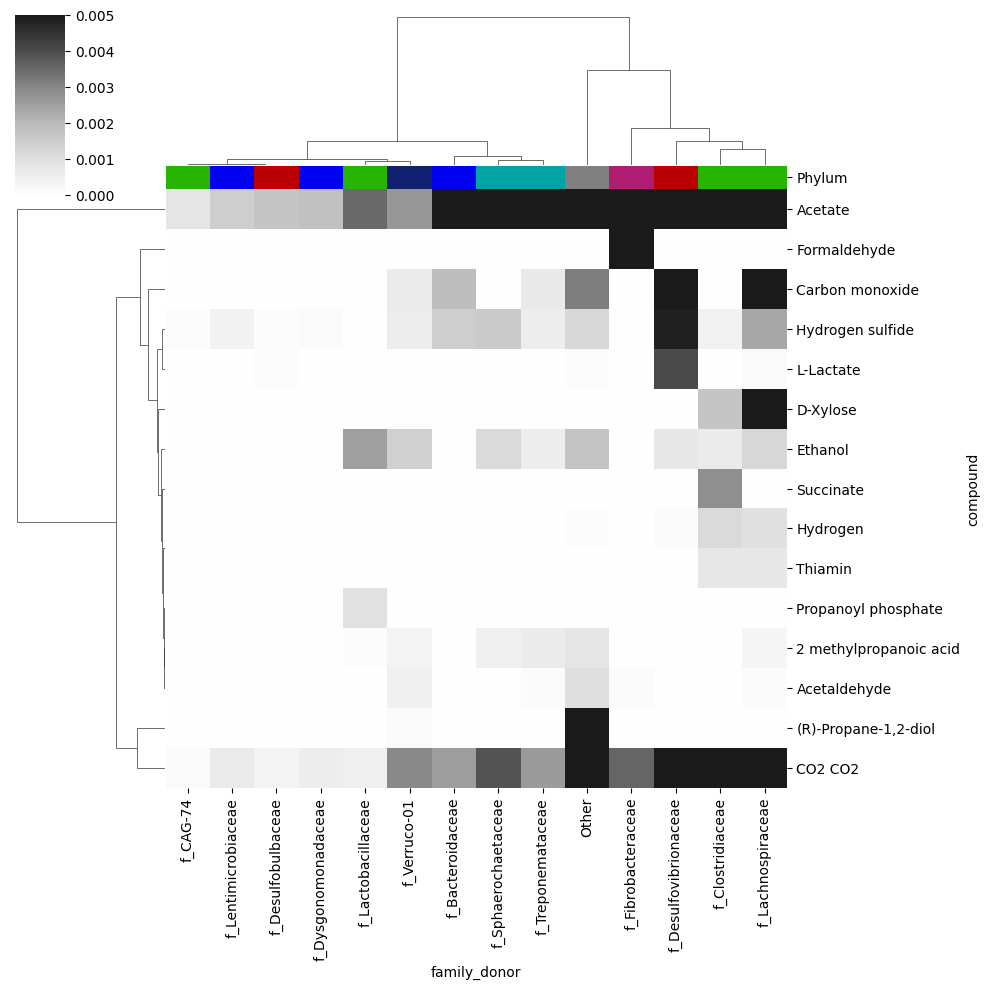

In [137]:
sns.clustermap(data=steadier_sample_prod_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               vmax=0.005,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=None,
               yticklabels=True)
              #figsize=(12,16))

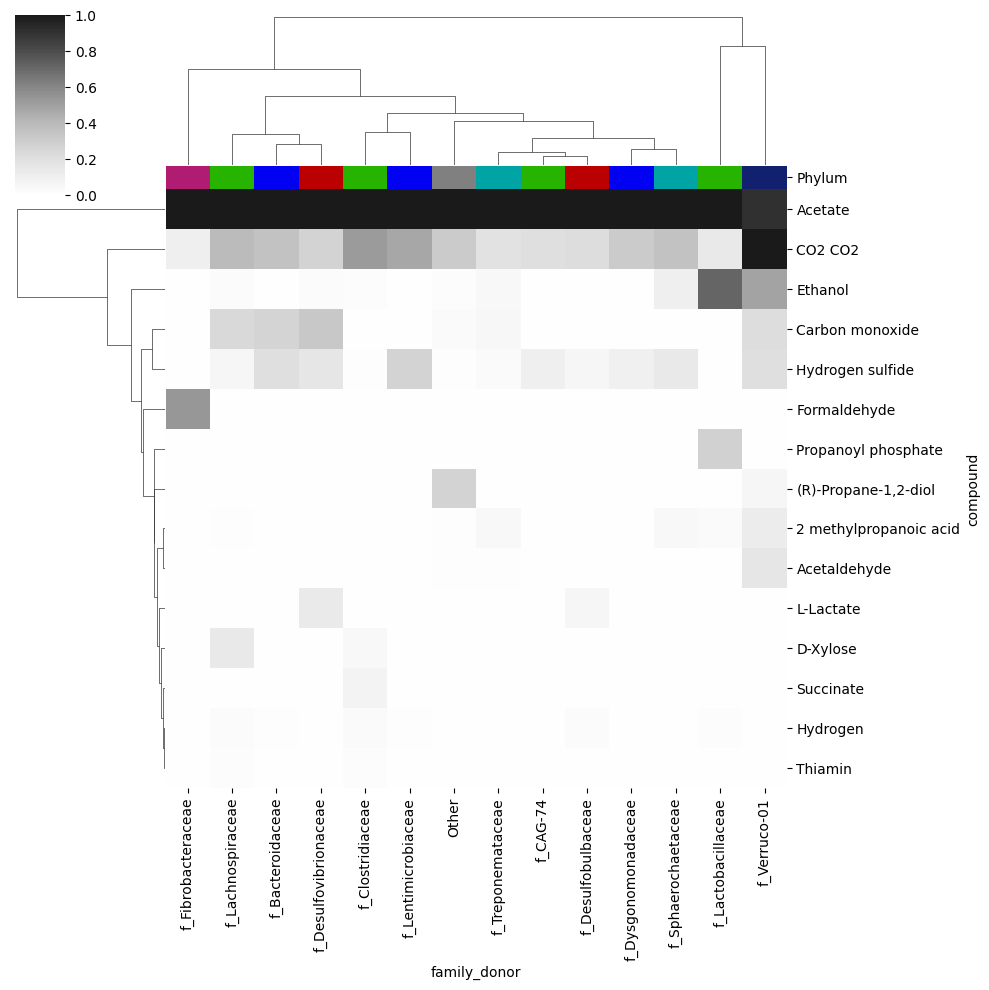

In [138]:
sns.clustermap(data=steadier_sample_prod_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               #vmax=0.005,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=1,
               yticklabels=True)
              #figsize=(12,16))

### Receiving - from other community members

In [139]:
steadier_sample_inter = steadier_sample[(steadier_sample.donor!="environment") & (steadier_sample.receiver!="environment") ].copy()

In [140]:
steadier_sample_inter["mass_rate*frequency"]=steadier_sample_inter["mass_rate"]*steadier_sample_inter["frequency"]

In [141]:
#steadier_sample_not_from_env["mass_rate*frequency"] = steadier_sample_not_from_env["mass_rate"]*steadier_sample_not_from_env["frequency"]

steadier_sample_inter_overview = steadier_sample_inter.groupby(["family_donor","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0)

In [142]:

steadier_sample_inter_overview = steadier_sample_inter_overview.loc[:,steadier_sample_inter_overview.sum()>1e-4]

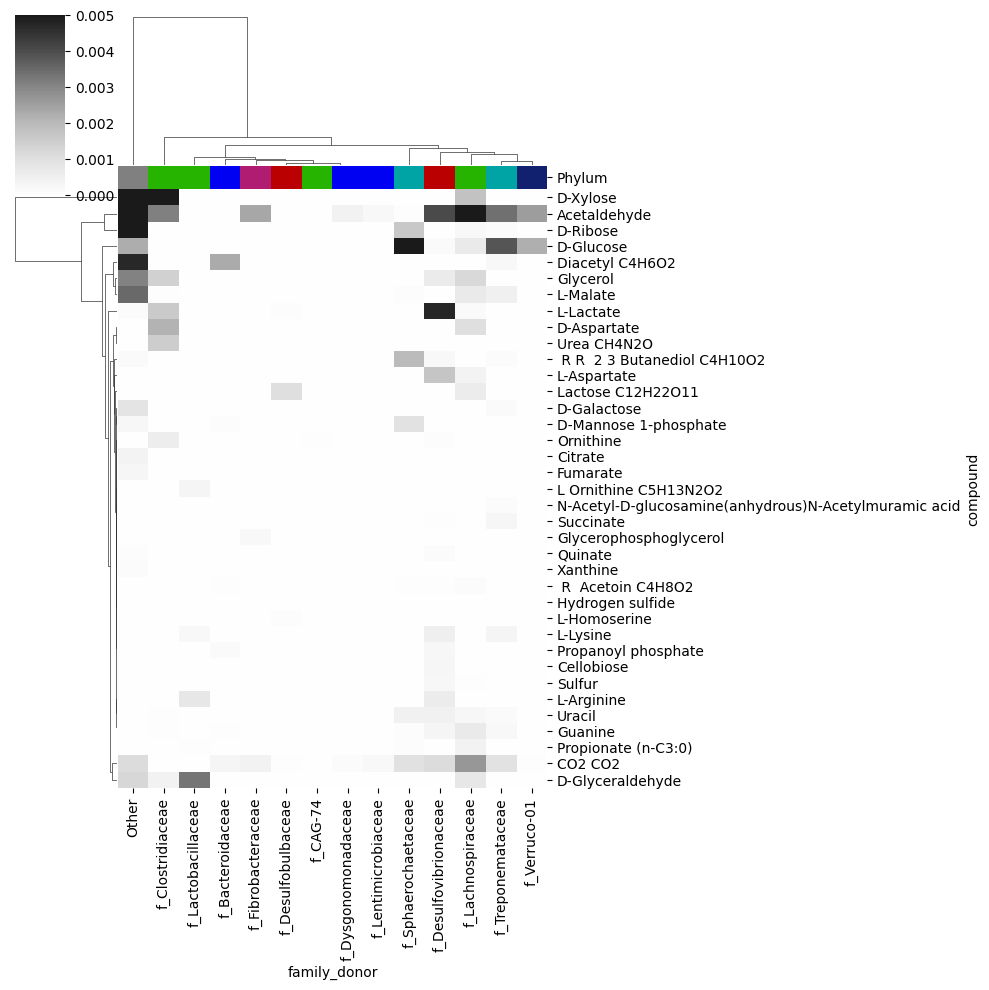

In [143]:
sns.clustermap(data=steadier_sample_inter_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               vmax=0.005,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=None,
               yticklabels=True)
              #figsize=(12,16))

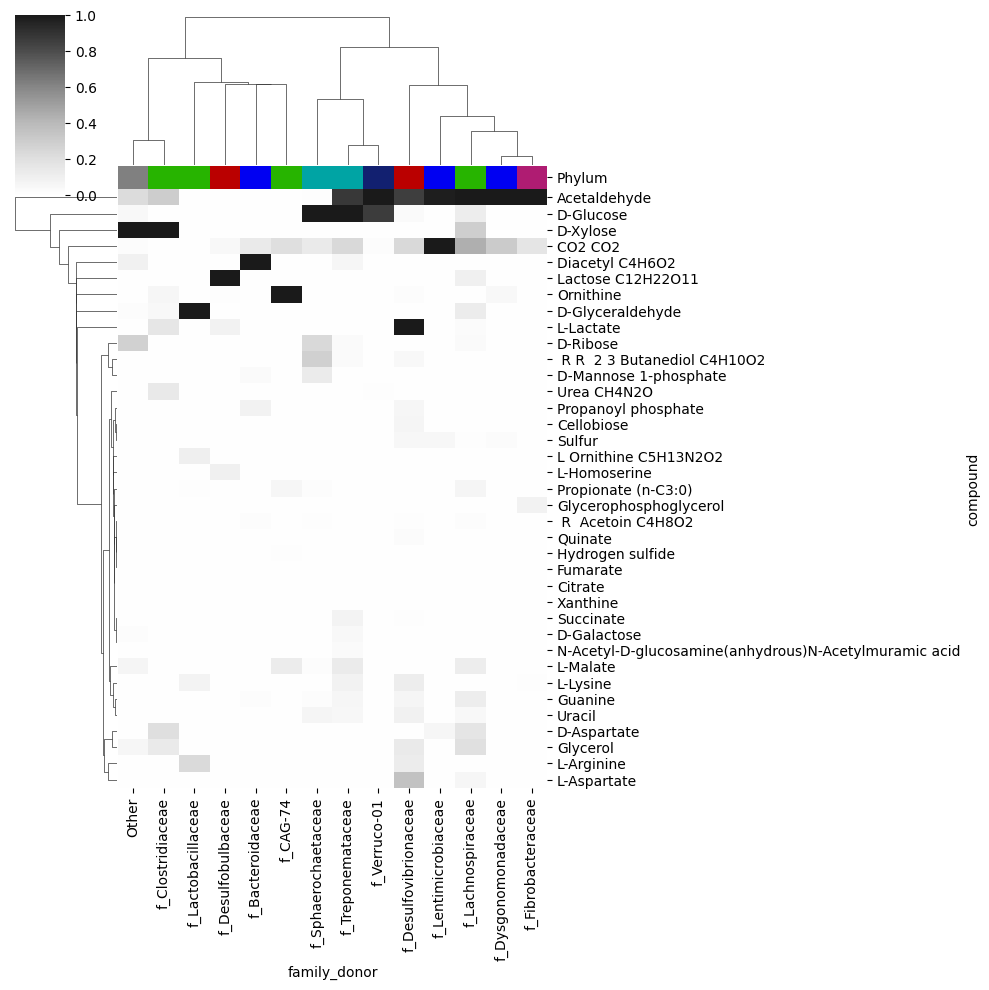

In [144]:
sns.clustermap(data=steadier_sample_inter_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               #vmax=0.005,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=1,
               yticklabels=True)
              #figsize=(12,16))

### Production - to environment or to another community member

In [145]:
steadier_sample_not_from_env = steadier_sample[steadier_sample.donor!="environment"].copy()

In [146]:
steadier_sample_not_from_env["mass_rate*frequency"]=steadier_sample_not_from_env["mass_rate"]*steadier_sample_not_from_env["frequency"]

In [147]:
steadier_sample_prod_overview = steadier_sample_not_from_env.groupby(["family_donor","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0)
steadier_sample_prod_overview = steadier_sample_prod_overview.loc[:,steadier_sample_prod_overview.sum()>1e-3]

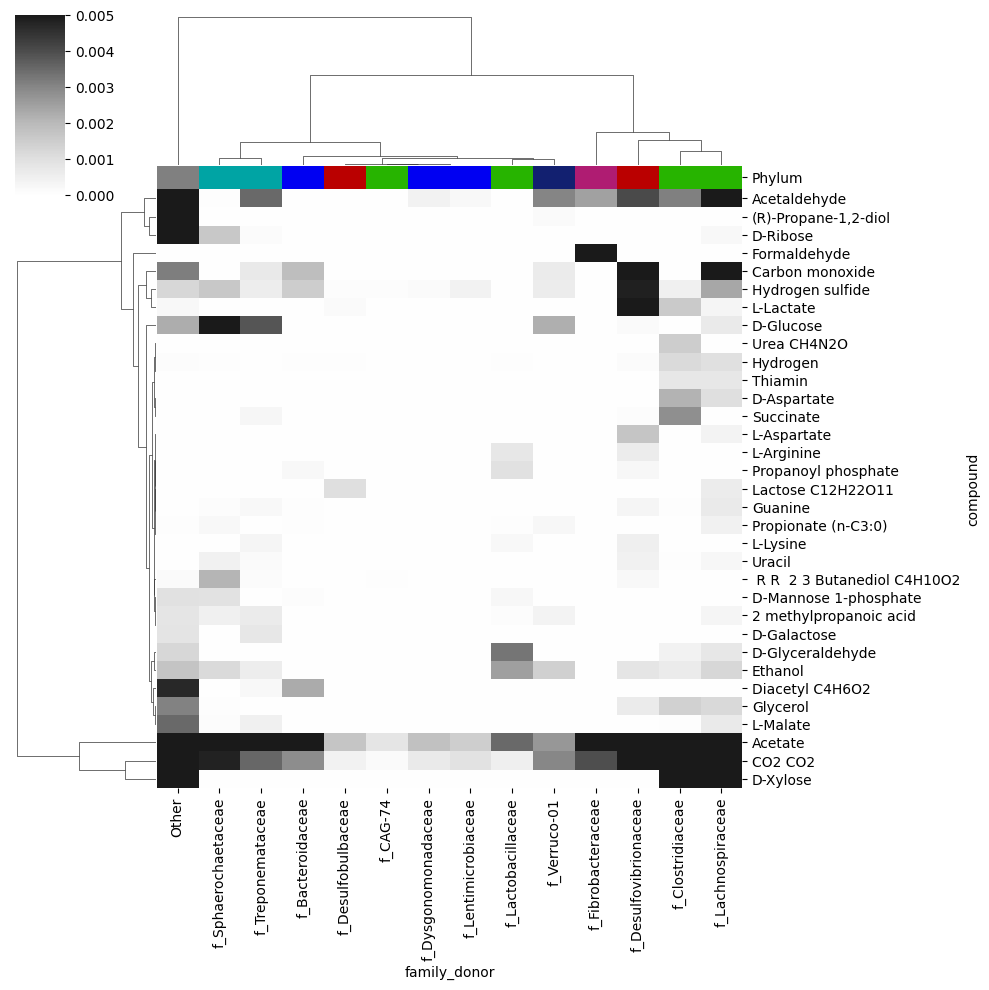

In [148]:
sns.clustermap(data=steadier_sample_prod_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               vmax=0.005,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=None,
               yticklabels=True)

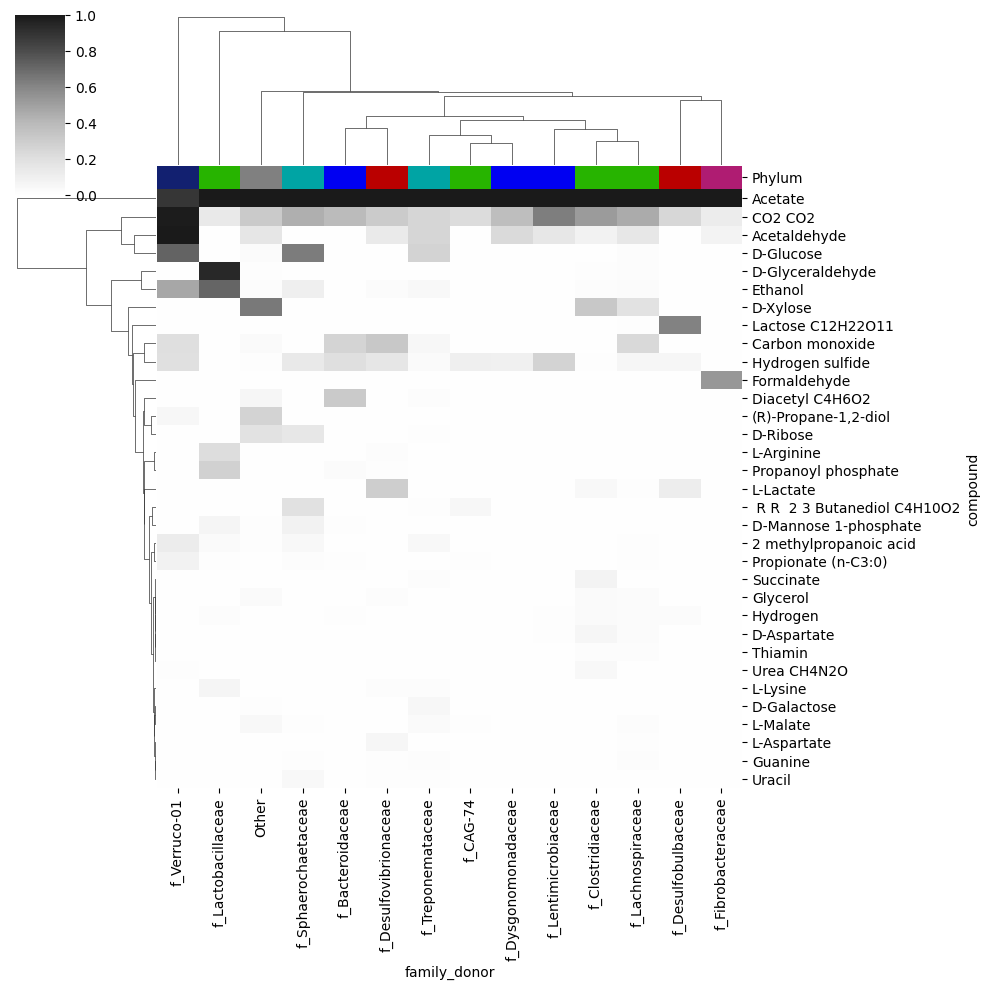

In [149]:
sns.clustermap(data=steadier_sample_prod_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               #vmax=0.05,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=1,
               yticklabels=True)

## Production/consumption with genus and family grouping

**Change names of family for readability and better grouping**

In [150]:
all_mags_paper_reduced = all_mags_paper.copy()

all_mags_paper_reduced[all_mags_paper_reduced["new_coverage"]>10][["Source","Substrate","Family","new_coverage"]].sort_values(["Source","Substrate"])

all_mags_paper_reduced["Family"] = all_mags_paper.apply(lambda row: "f_"+row.Family + "_g_"+row.Genus if isinstance(row.Genus,str) else "f_"+row.Family,axis=1)

total_members_family = all_mags_paper_reduced.groupby("Family").count()["Source"].to_dict()
#all_mags_paper_reduced["Family"] = all_mags_paper_reduced.apply(lambda row: row.Family if total_members_family[row.Family]>1 else "Other",axis=1)


**Create dictionaries to translate components into larger groups - MAG-> family, compound-> super_class**

In [151]:
MAGs_steady_com = list(set(steadier_sample_prod.donor.values))

MAG2sour_sub_id = pd.read_csv("../output/MAG2community_id.tsv",sep="\t",header=None)
MAG2sour_sub_id.columns=["MAG","community_id"]

met2superclass_dict = pd.read_csv("../output/met_chebi_class.tsv",sep="\t",index_col=0)["self defined super class"].to_dict()

family_groups,mag2family_dict = mag2family(all_mags_paper_reduced)

**Process samples**

In [152]:
SC1_C = pd.read_csv("../output/steadiercom_sample_0.1.3/results/results_99_SC1_C.tsv",sep="\t")
SC2_C = pd.read_csv("../output/steadiercom_sample_0.1.3/results/results_99_SC2_C.tsv",sep="\t")
SC1_X = pd.read_csv("../output/steadiercom_sample_0.1.3/results/results_99_SC1_X.tsv",sep="\t")

steadier_sample = pd.concat([SC1_C,SC2_C,SC1_X])
steadier_sample = steadier_sample[(steadier_sample.frequency>0.1) & (steadier_sample.rate>1e-6)]

In [153]:
steadier_sample.loc[:,"family_donor"] = steadier_sample.apply(family_donor,axis=1).copy()
steadier_sample.loc[:,"family_receiver"] = steadier_sample.apply(family_receiver,axis=1).copy()
steadier_sample = steadier_sample[steadier_sample.compound.isin(met2superclass_dict.keys())].copy()
steadier_sample.loc[:,"super_class"] = steadier_sample.apply(lambda x: met2superclass_dict[x.compound],axis=1)

compounds = steadier_sample["compound"].map(met2metname)
steadier_sample.drop("compound",axis=1,inplace=True)
steadier_sample.loc[:,"compound"] = compounds
steadier_sample["mass_rate*frequency"]=steadier_sample["mass_rate"]*steadier_sample["frequency"]

**Create colors**

In [154]:
phyla_lut, unique_phyla, phylum_colors = color_func.phylum_colors_func()

families = list(set(list(steadier_sample.family_donor.unique()) + list(steadier_sample.family_receiver.unique())))

In [155]:
#families.remove("Other")
families.remove("environment")

phyla = [all_mags_paper.loc[all_mags_paper.loc[all_mags_paper.Family==family.split("_")[1]].index]["Phylum"][0] for family in families]
colors = [phyla_lut[phylum] for phylum in phyla]

#families.append("Other")
#colors.append("#808080")

color_df = pd.DataFrame({"Family_names":families,"Phylum":colors})
color_df.set_index("Family_names",inplace=True)

### Production  - only compounds released in environment

In [156]:
steadier_sample_prod = steadier_sample[(steadier_sample.receiver=="environment") ].copy()

In [157]:
#steadier_sample_not_from_env["mass_rate*frequency"] = steadier_sample_not_from_env["mass_rate"]*steadier_sample_not_from_env["frequency"]

steadier_sample_prod_overview = steadier_sample_prod.groupby(["family_donor","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0)

In [158]:

steadier_sample_prod_overview = steadier_sample_prod_overview.loc[:,steadier_sample_prod_overview.sum()>1e-3]

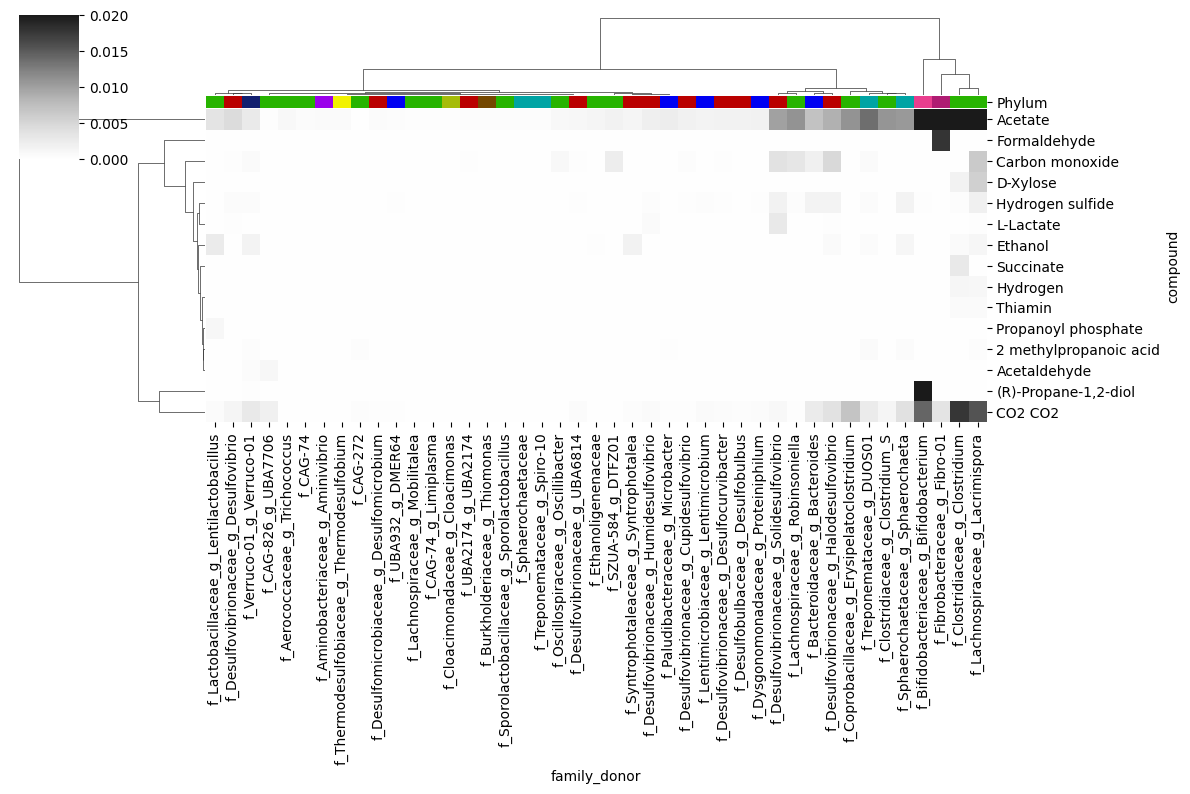

In [159]:
sns.clustermap(data=steadier_sample_prod_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               vmax=0.02,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=None,
               yticklabels=True,
              xticklabels=True,
              figsize=(12,8))

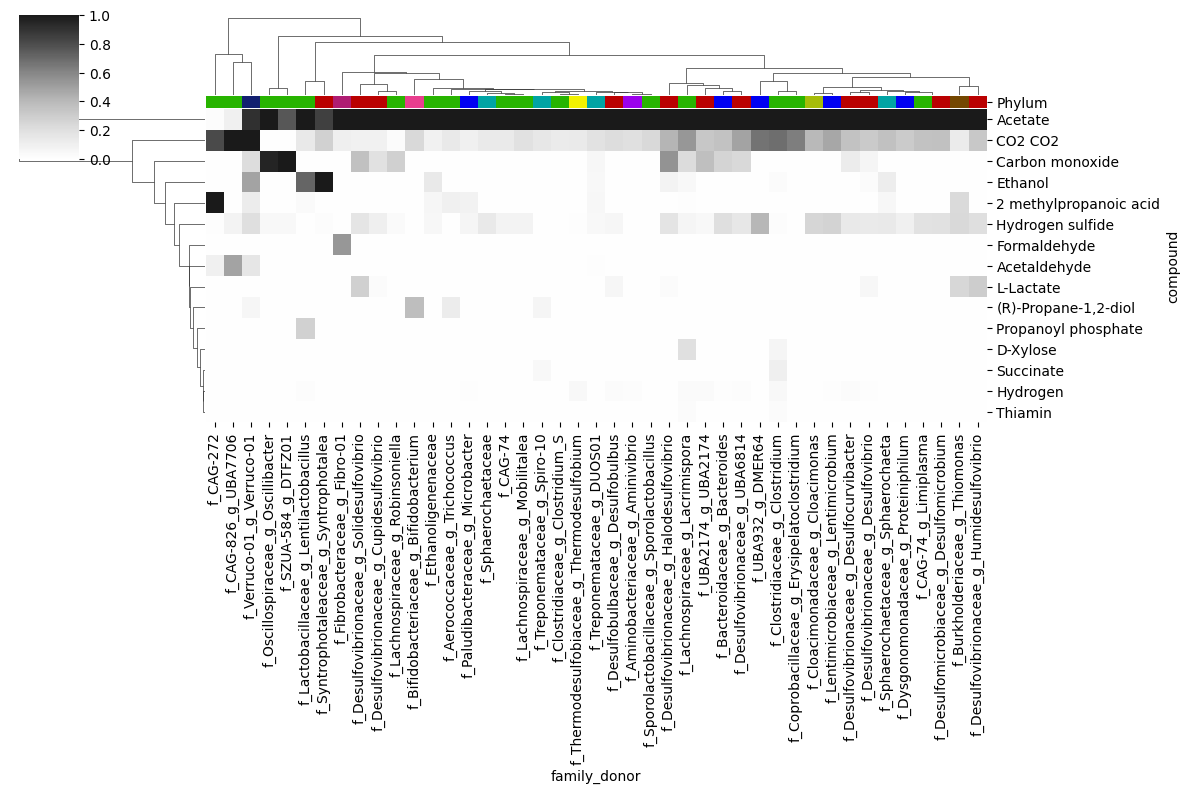

In [160]:
sns.clustermap(data=steadier_sample_prod_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               #vmax=0.005,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=1,
              xticklabels=True,
              figsize=(12,8))

### Production - to environment or to another community member

In [161]:
steadier_sample_not_from_env = steadier_sample[steadier_sample.donor!="environment"].copy()

In [162]:
steadier_sample_prod_overview = steadier_sample_not_from_env.groupby(["family_donor","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0)
steadier_sample_prod_overview = steadier_sample_prod_overview.loc[:,steadier_sample_prod_overview.sum()>1e-3]

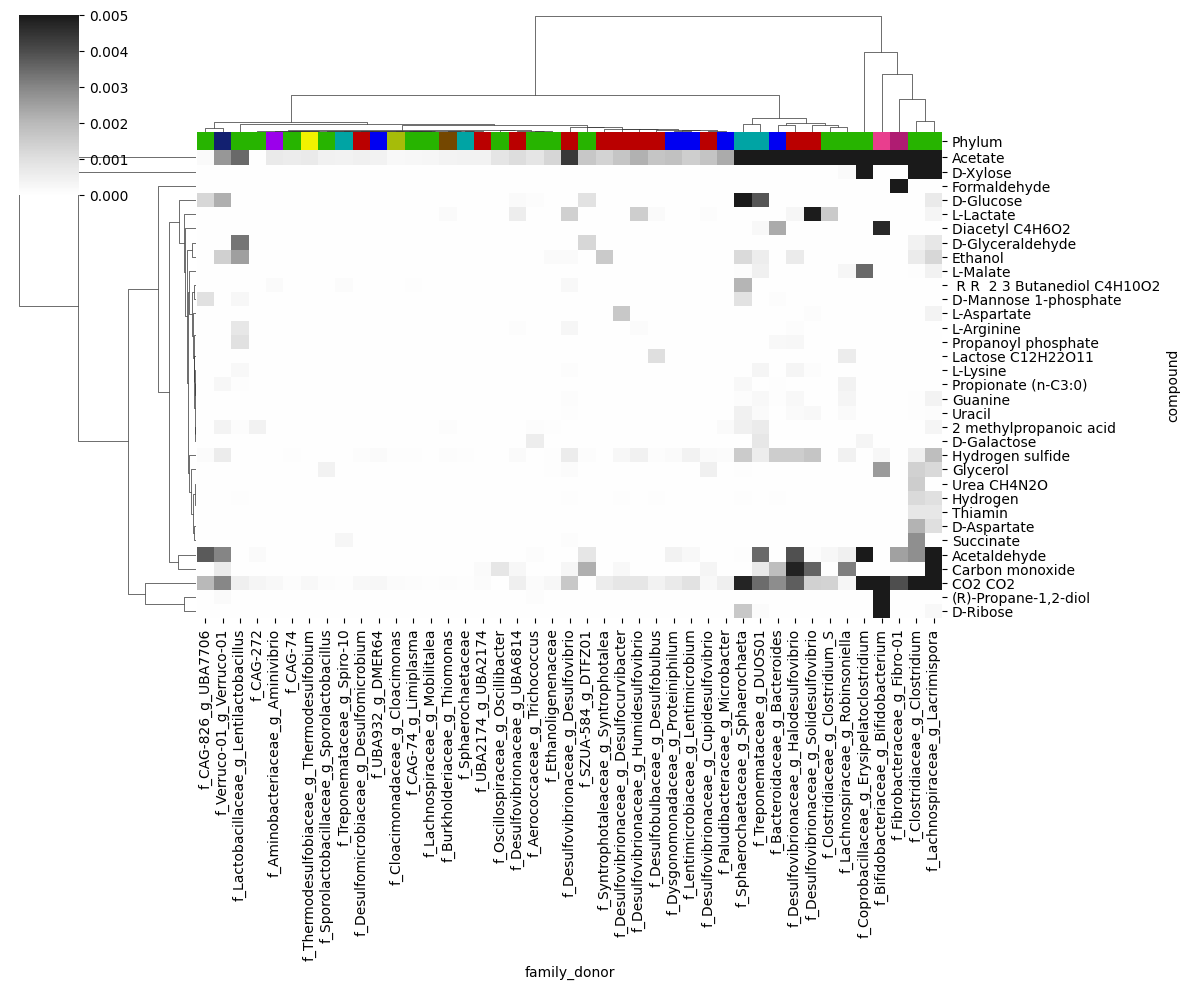

In [163]:
sns.clustermap(data=steadier_sample_prod_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               vmax=0.005,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=None,
               yticklabels=True,
               xticklabels=True,
              figsize=(12,10))

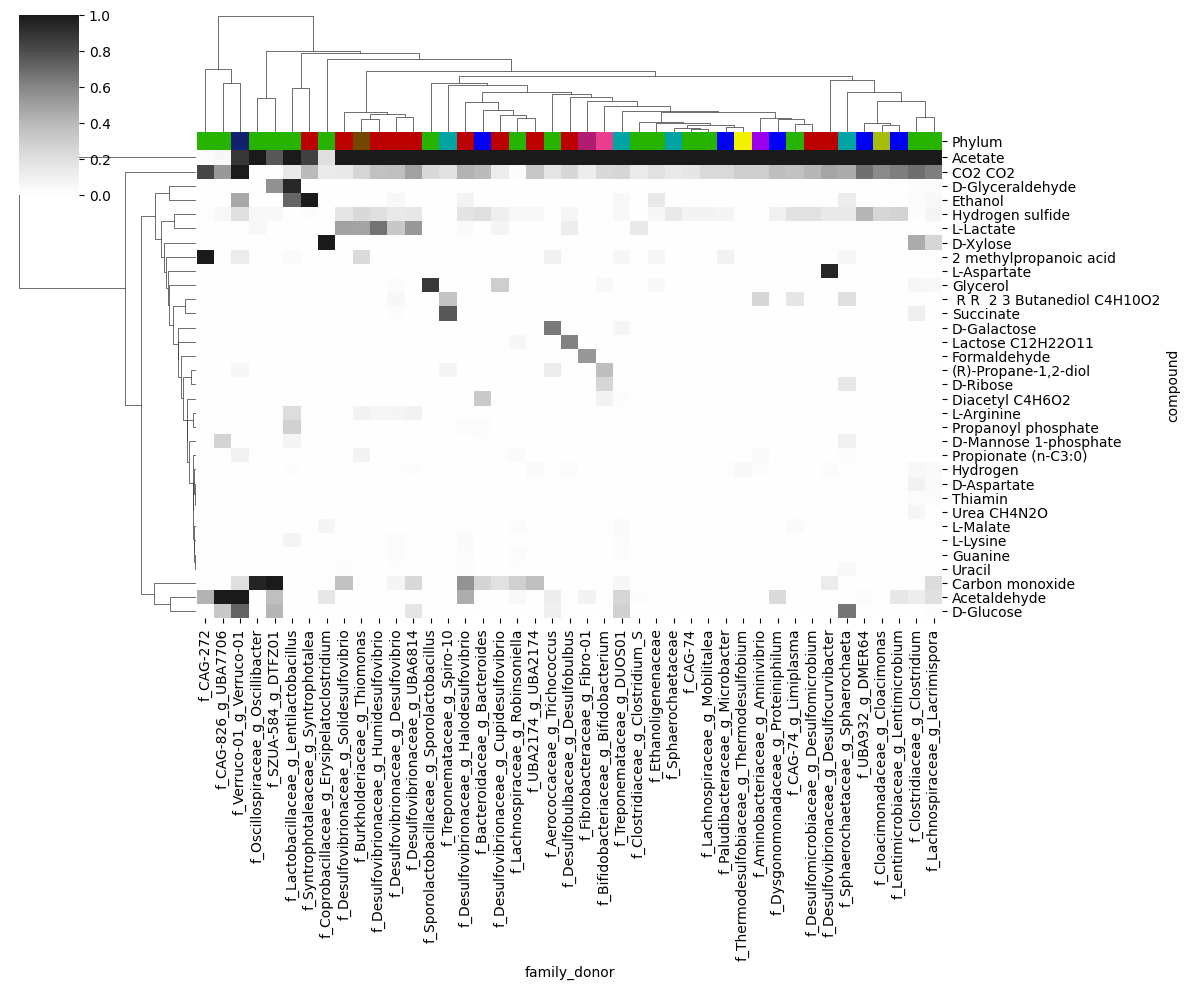

In [164]:
sns.clustermap(data=steadier_sample_prod_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               #vmax=0.05,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=1,
               yticklabels=True,
               xticklabels=True,
              figsize=(12,10),
              )

#### Suspected lactate producers

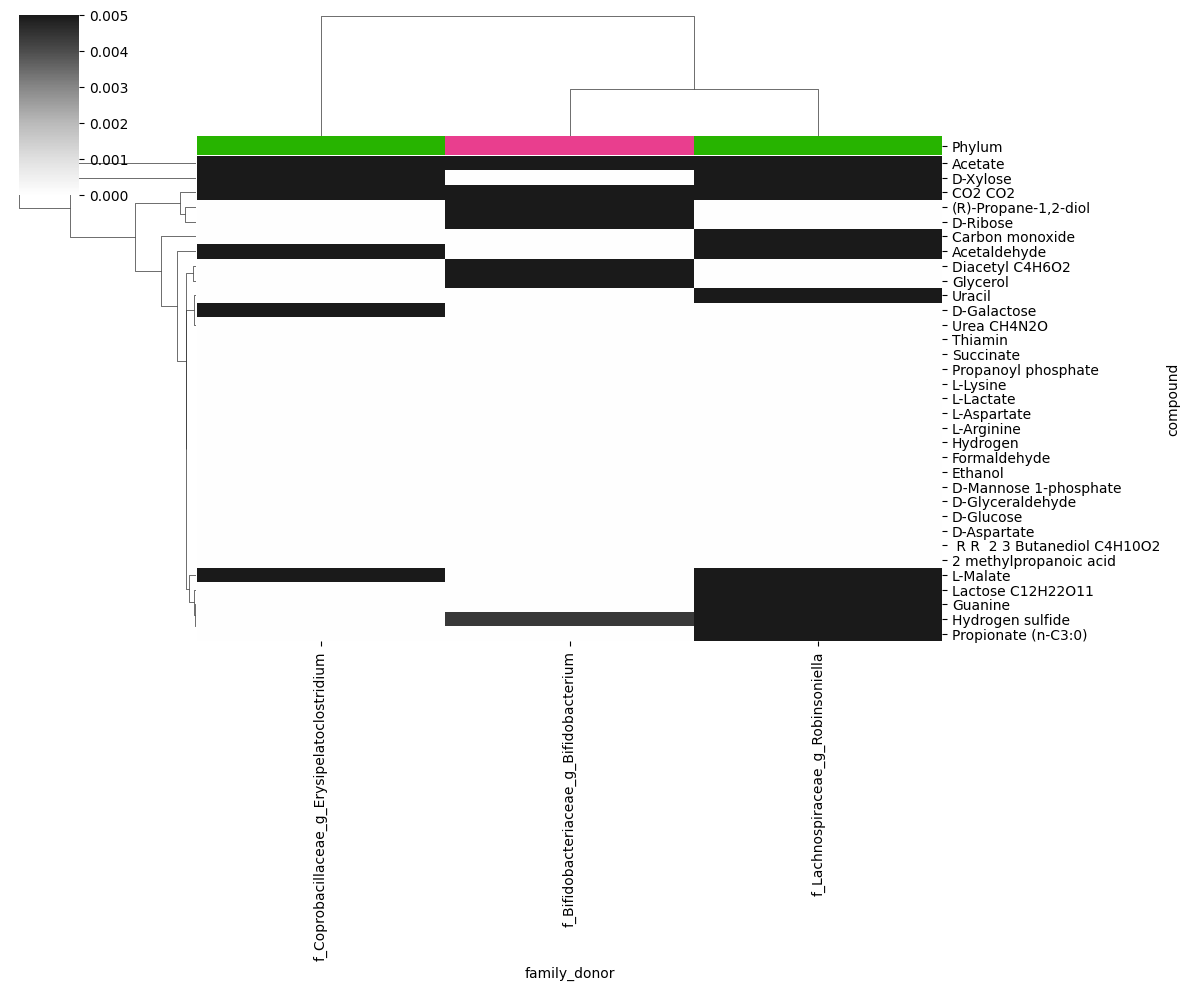

In [165]:
sns.clustermap(data=steadier_sample_prod_overview.loc[(steadier_sample_prod_overview.index.str.contains("Bifidobacteriaceae")) |
                                 (steadier_sample_prod_overview.index.str.contains("Robinsoniella")) | 
                                 (steadier_sample_prod_overview.index.str.contains("Erysipelatoclostridium"))].T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               vmax=0.005,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=1,
               yticklabels=True,
              xticklabels=True,
              figsize=(12,10))

#### Suspected organic acid producers

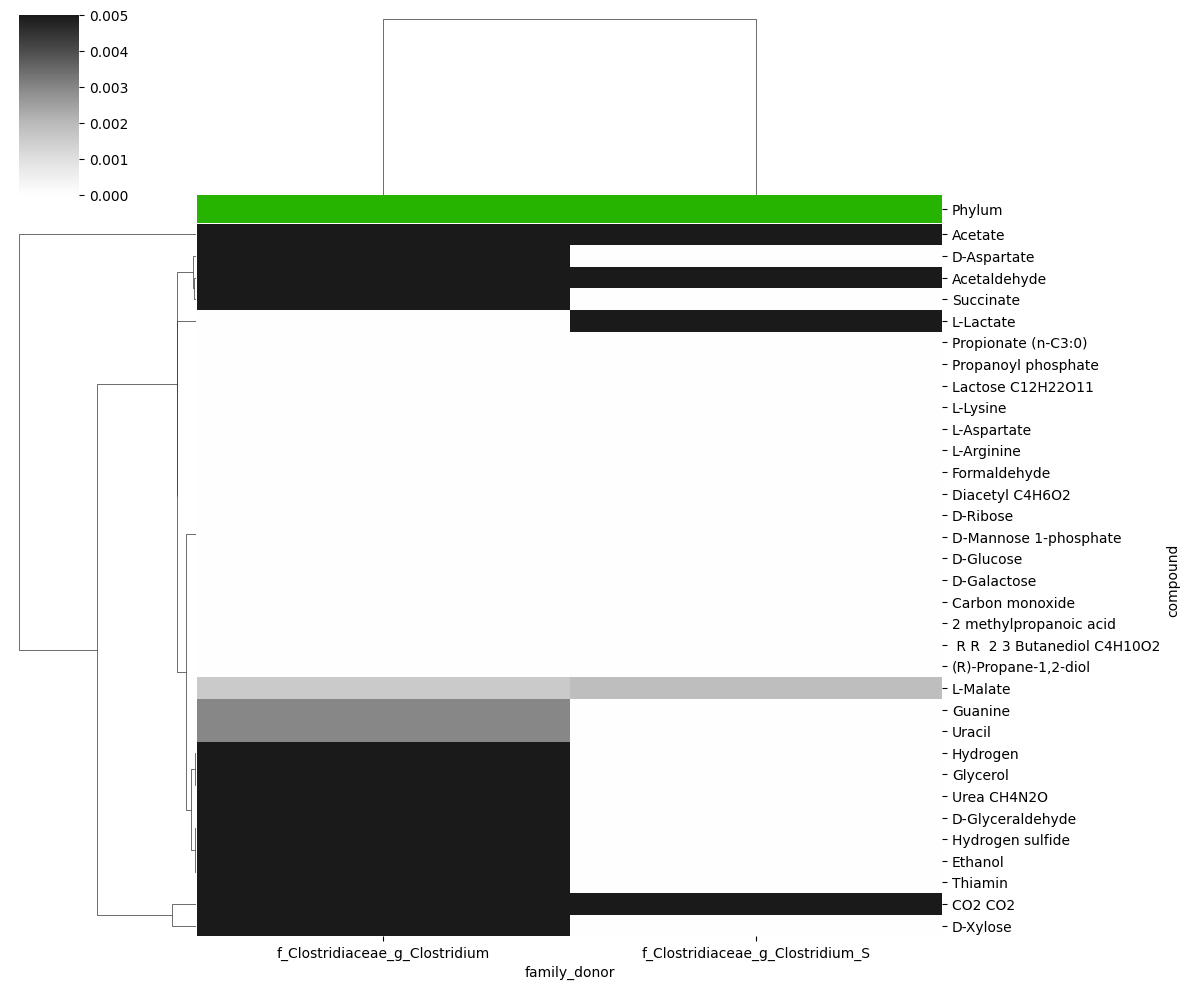

In [166]:
sns.clustermap(data=steadier_sample_prod_overview.loc[(steadier_sample_prod_overview.index.str.contains("Clostridium"))].T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               vmax=0.005,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=1,
               yticklabels=True,
              xticklabels=True,
              figsize=(12,10))

#### Suspected propionic acid producers

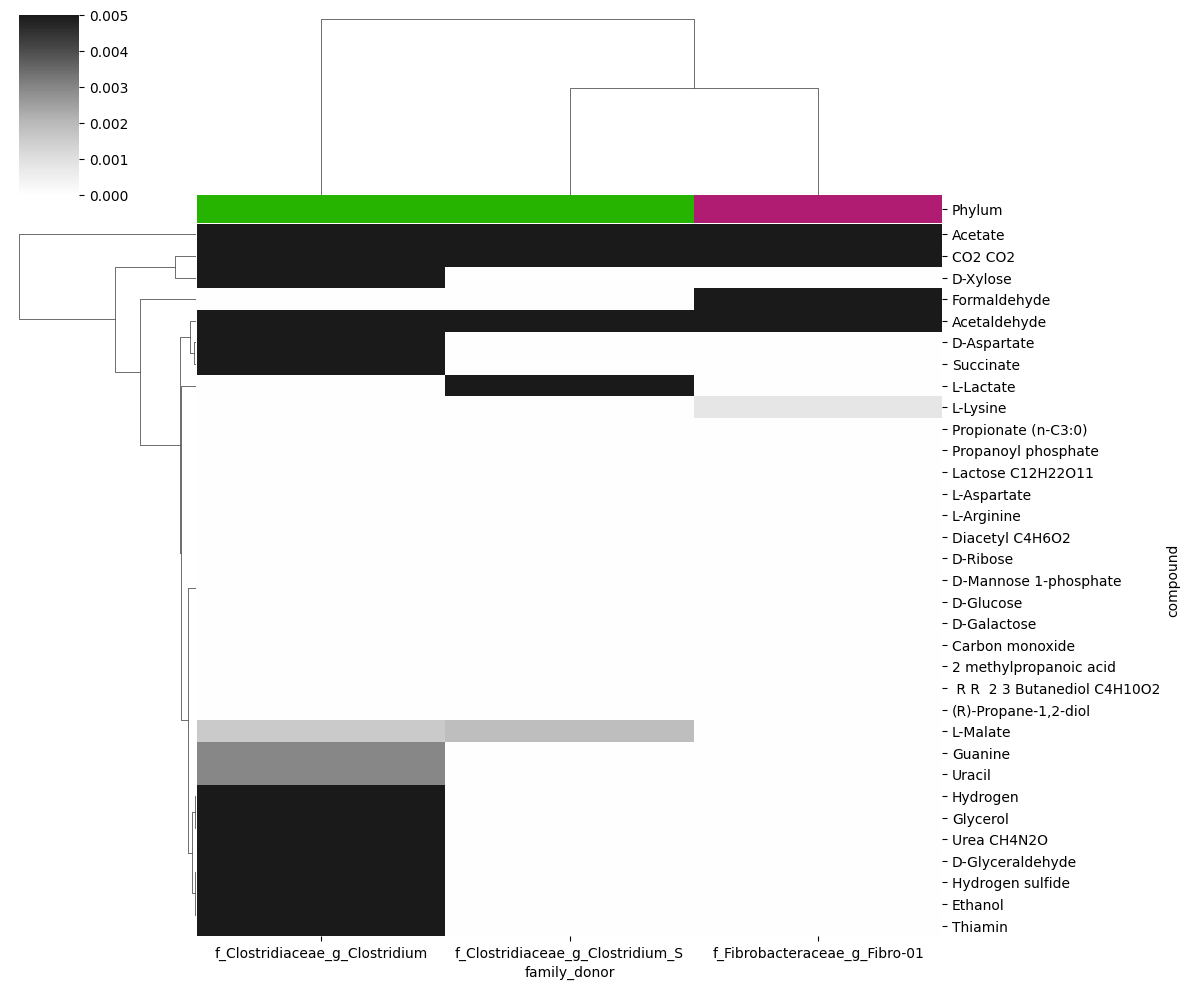

In [167]:
sns.clustermap(data=steadier_sample_prod_overview.loc[(steadier_sample_prod_overview.index.str.contains("Fibro")) | 
                                                     (steadier_sample_prod_overview.index.str.contains("Clostridia"))].T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               vmax=0.005,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=1,
               yticklabels=True,
              xticklabels=True,
              figsize=(12,10))

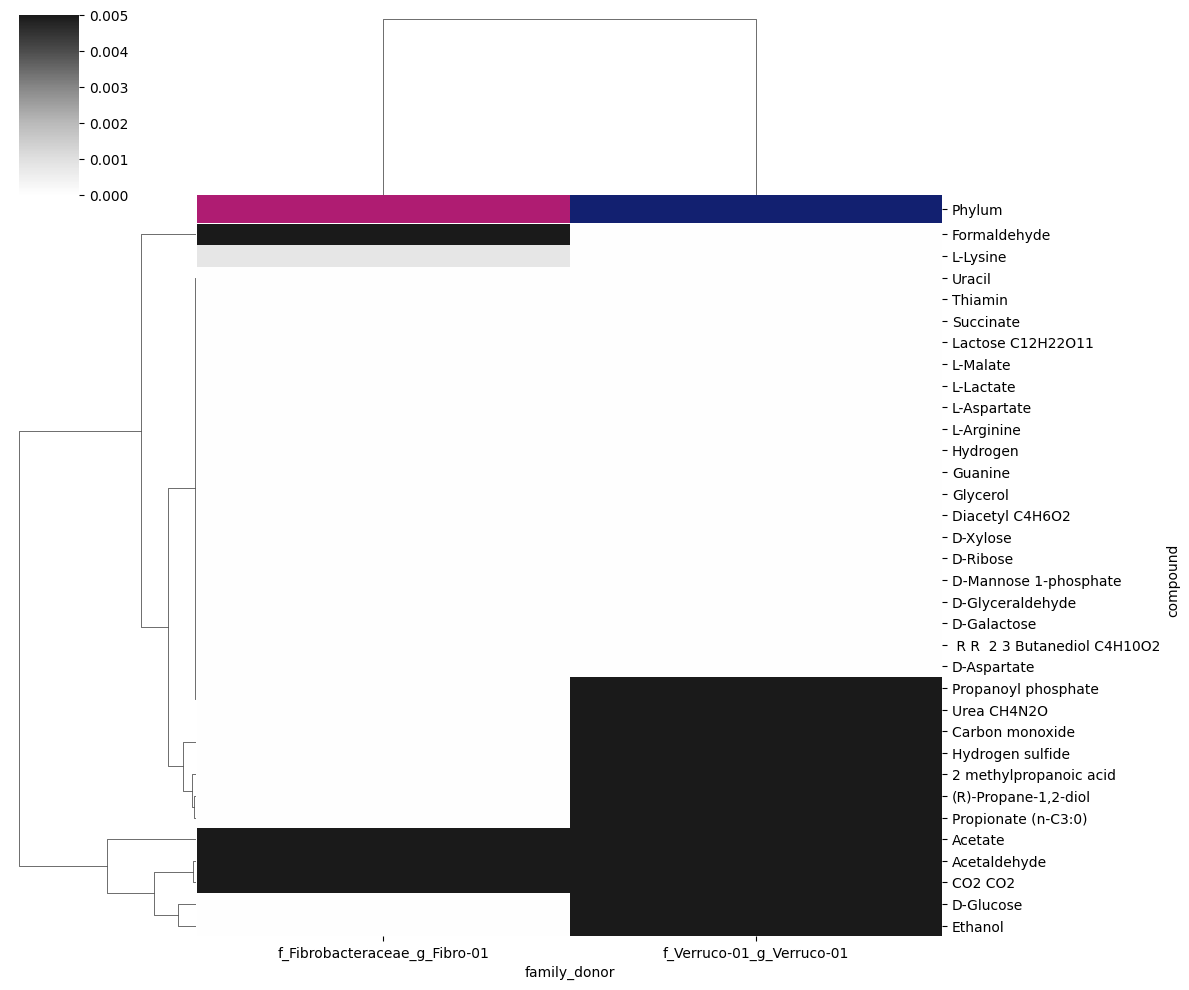

In [168]:
sns.clustermap(data=steadier_sample_prod_overview.loc[(steadier_sample_prod_overview.index.str.contains("Fibro")) | 
                                                     (steadier_sample_prod_overview.index.str.contains("Verruco"))].T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               vmax=0.005,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=1,
               yticklabels=True,
              xticklabels=True,
              figsize=(12,10))

### Receiving - from environment or another communtiy member

In [169]:
steadier_sample_not_to_env = steadier_sample[steadier_sample.receiver!="environment"].copy()
steadier_sample_not_to_env["mass_rate*frequency"] = steadier_sample_not_to_env["mass_rate"]*steadier_sample_not_to_env["frequency"]

In [170]:

steadier_sample_rec_overview = steadier_sample_not_to_env.groupby(["family_receiver","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0)

steadier_sample_rec_overview = steadier_sample_rec_overview.loc[:,steadier_sample_rec_overview.sum()>1e-3]

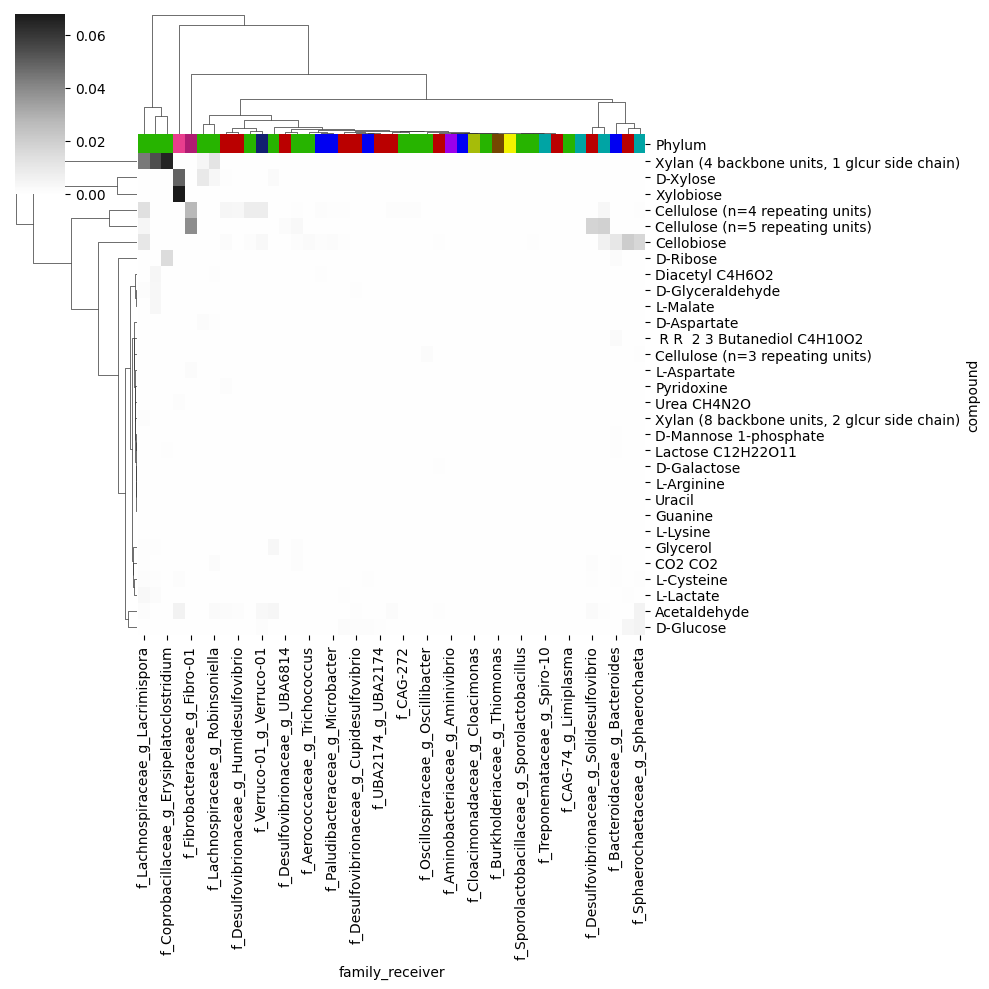

In [171]:
sns.clustermap(data=steadier_sample_rec_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               #vmax=0.05,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=None,
               yticklabels=True)

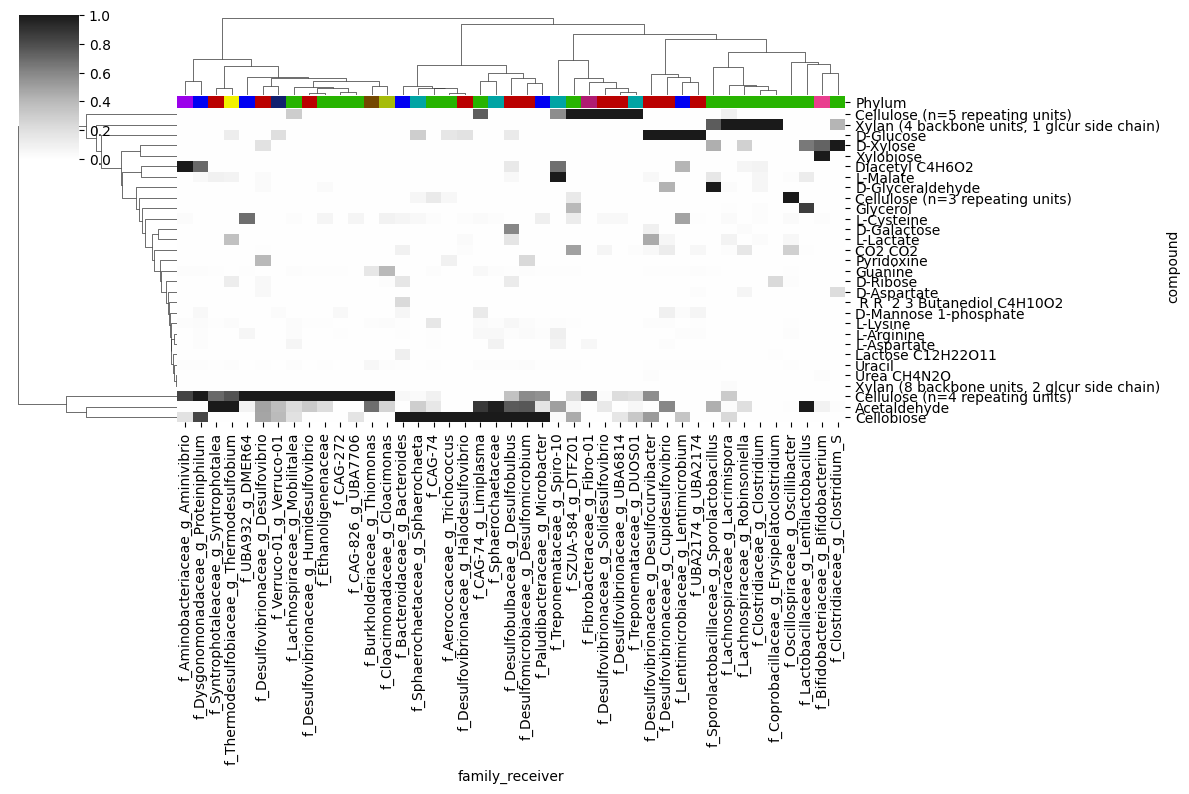

In [172]:
sns.clustermap(data=steadier_sample_rec_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               #vmax=0.05,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=1,
               yticklabels=True,
               xticklabels=True,
              figsize=(12,8))

## Community members receiving (Only interactions)

In [173]:
steadier_sample_inter = steadier_sample[(steadier_sample.receiver!="environment") & (steadier_sample.donor!="environment")].copy()
steadier_sample_inter["mass_rate*frequency"] = steadier_sample_inter["mass_rate"]*steadier_sample_inter["frequency"]

In [174]:

steadier_sample_rec_overview = steadier_sample_inter.groupby(["family_receiver","compound"]).sum()["mass_rate*frequency"].unstack().fillna(0)

steadier_sample_rec_overview = steadier_sample_rec_overview.loc[:,steadier_sample_rec_overview.sum()>1e-3]

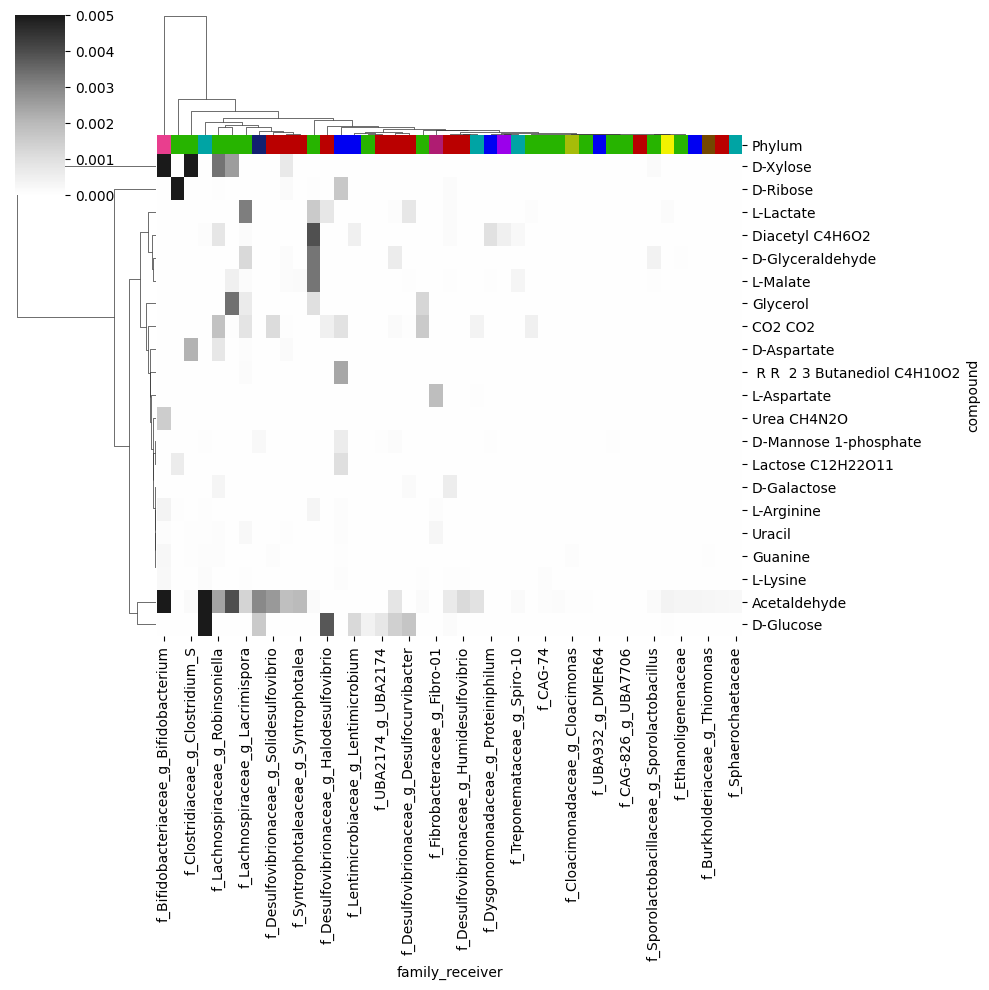

In [175]:
sns.clustermap(data=steadier_sample_rec_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               vmax=0.005,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=None,
               yticklabels=True)

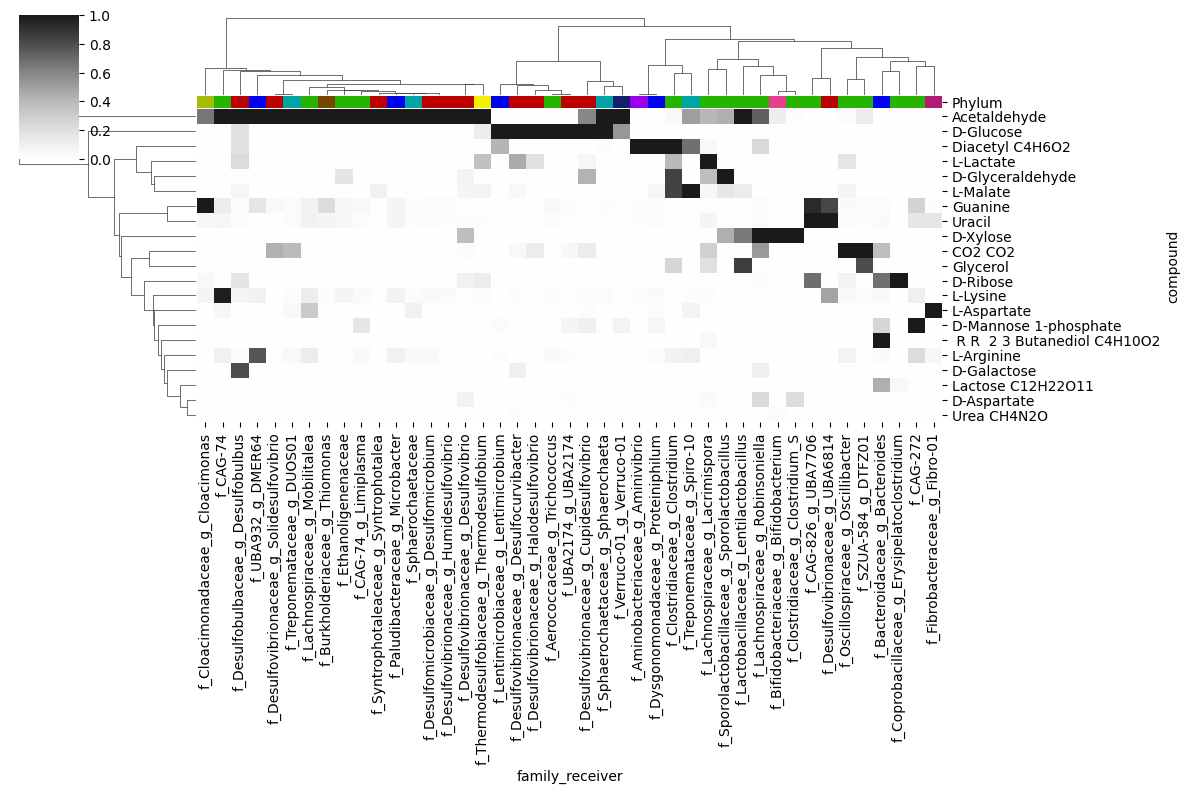

In [176]:
sns.clustermap(data=steadier_sample_rec_overview.T, 
               cmap="RdGy",
               center=0,
               vmin=0,
               #vmax=0.05,
               method="ward",
               metric="euclidean",
               col_colors=color_df,
               z_score=None,
               standard_scale=1,
               yticklabels=True,
               xticklabels=True,
              figsize=(12,8))

## Production of alternative fermentation products

In [177]:
SC1_C = pd.read_csv("../output/steadiercom_sample_0.1.3/results/results_99_SC1_C.tsv",sep="\t")
SC2_C = pd.read_csv("../output/steadiercom_sample_0.1.3/results/results_99_SC2_C.tsv",sep="\t")
SC1_X = pd.read_csv("../output/steadiercom_sample_0.1.3/results/results_99_SC1_X.tsv",sep="\t")

steadier_sample = pd.concat([SC1_C,SC2_C,SC1_X])
#steadier_sample = steadier_sample[(steadier_sample.frequency>0.1) & (steadier_sample.rate>1e-6)]

In [178]:
steadier_sample_prod = steadier_sample[(steadier_sample.receiver=="environment") ].copy()

In [179]:
steadier_sample_prod[(steadier_sample_prod.community.isin(["CD_X","CM_X","M_X"]))&(steadier_sample_prod.compound.isin(["M_lac__L_e","M_etoh_e","M_succ_e"]))]

,donor,receiver,compound,mass_rate,rate,frequency,community,medium
31,CH14-bin.1,environment,M_etoh_e,0.005513,0.119663,0.22,CD_X,SC1_X
36,CH3-bin.2,environment,M_etoh_e,0.004882,0.105979,0.13,M_X,SC1_X
47,CH9-bin.2,environment,M_succ_e,0.002843,0.024491,0.99,CM_X,SC1_X
51,CH9-bin.4,environment,M_etoh_e,0.002506,0.054408,1.00,CM_X,SC1_X
79,CH3-bin.1,environment,M_lac__L_e,0.000949,0.010659,0.02,M_X,SC1_X
105,CH14-bin.4,environment,M_etoh_e,0.000506,0.010977,0.27,CD_X,SC1_X
126,CH3-bin.2,environment,M_succ_e,0.000389,0.003355,0.09,M_X,SC1_X
155,CH14-bin.4,environment,M_lac__L_e,0.000226,0.002534,0.08,CD_X,SC1_X
220,CH14-bin.4,environment,M_succ_e,0.000031,0.000265,0.52,CD_X,SC1_X
223,CH9-bin.5,environment,M_succ_e,0.000028,0.000245,0.01,CM_X,SC1_X
